In [1]:
%load_ext autoreload
%autoreload 2

# Full Wave Inversion

This tutorial shows how to develop Full Waveform Inversion algorithms with `jwave`. To highlight the ability of customizing the inversion algorithm, we'll add a smoothing step to the gradient computation before performing the gradient descent step with the Adam optimizer.

The inversion will be taken with respect to the **density** of the medium.

## Setup simulation
Let's start by importing the required modules

In [2]:
import numpy as np
from jax import numpy as jnp
from jax import random, nn, value_and_grad, jit, grad, vmap
from jax import lax
from jax.example_libraries import optimizers
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt

from jwave.geometry import Domain, Medium, TimeAxis, Sources, _circ_mask, _points_on_circle, Sensors
from jwave.signal_processing import gaussian_window, apply_ramp, smooth, analytic_signal
from jwave.acoustics import simulate_wave_propagation
from jwave import FourierSeries

The first step is to define the simulation settings, from the geometrical properties of the domain to the sources and receivers.

In [128]:
# Settings
N = (128, 128)
dx = (.5, .5)
cfl = 0.25
num_sources = 32
source_freq = .5
source_mag = 5
random_seed = random.PRNGKey(42)

# Define domain
domain = Domain(N, dx)

# Define medium
sound_speed = jnp.ones(N) 
circle_1 = _circ_mask(N, 8, (50,50))
circle_2 = _circ_mask(N, 10, (78,64))
circle_3 = _circ_mask(N, 20, (65,65))
sound_speed = sound_speed + 0.15*circle_1 + 0.07*circle_2 + 0.03*circle_3
sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)

medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20.)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl, t_end=80.)

# Sources
source_mag = source_mag/time_axis.dt
t = time_axis.to_array()
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 10, 4)
x, y = _points_on_circle(num_sources,40,(64,64))
source_positions = (jnp.array(x), jnp.array(y))

# Sensors
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

Let's visualize the simulation settings to get a better understanding of the setup:

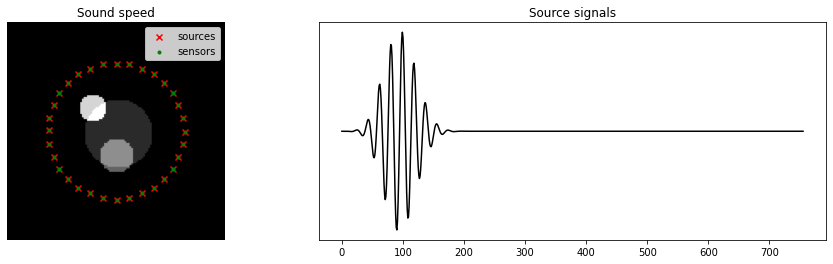

In [129]:
# Show simulation setup
fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='.', label="sensors")
ax[0].legend()
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c='k')
ax[1].set_title("Source signals")
ax[1].get_yaxis().set_visible(False)

## Run the simulation

At this point, we can use the `ongrid_wave_propagation` constructor to generate a function that takes two inputs: the speed of sound map, and the index of one of the source points. This function then evaluates the result of propagating, with the given sound speed map, a pulse transmitted from the requested sensor.

In [130]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled 
# and run only once.
@jit 
def single_source_simulation(sound_speed, source_num):
    # Setting source
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x,y), src_signal, dt=time_axis.dt, domain=domain)
    
    # Updating medium with the input speed of sound map
    medium = Medium(
        domain=domain,
        sound_speed=sound_speed,
        pml_size=20
    )
    
    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[...,0]

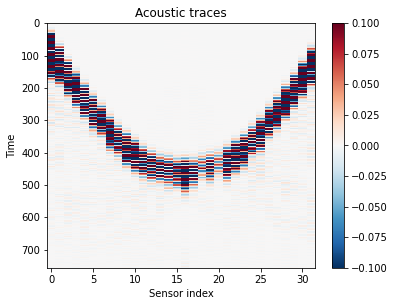

In [131]:
p = single_source_simulation(medium.sound_speed, 0)

# Visualize the acoustic traces
plt.figure(figsize=(6,4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(p, cmap="RdBu_r", vmin=-.1, vmax=.1, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

Since the entire function is compiled, it shows good execution times, more so on GPU accelerators (since FFT is fast on them):

In [132]:
%%timeit
single_source_simulation(medium.sound_speed, 1).block_until_ready()

55.6 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Because we can apply arbitrary function transformations on the simulation code, we can use `vmap` to efficiently parallelize the simulation for all sources. We'll use it as a fast method to generate all the snapshots used as data.

In [133]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (32, 757, 32)


Note that the execution time is smaller than 32$\times$ the single source simulation runtime

In [134]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(num_sources)).block_until_ready()

513 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


At last, let's add some coloured noise to the data that we'll use for inversion.

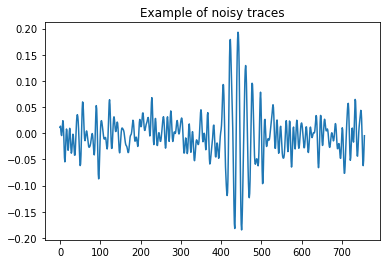

In [135]:
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
noise = np.random.normal(size=p_data.shape)*0.05
noise = jnp.fft.fft(noise, axis=1)
noise = noise.at[:,100:-100].set(0.)
noise = jnp.fft.ifft(noise, axis=1).real
p_data = p_data + noise

plt.plot(p_data[12,:,0])
plt.title("Example of noisy traces")
plt.show()

## Define the optimization problem

We'll let `autodiff` generate the full wave inversion algorithm. To do so, we need to specify a forward model that maps the speed of sound map to the acoustic data. 

While this has already be done in the previous cells of this notebook, we'll wrap it around a new function used to reparametrize the speed of sound map. This is done because the forward simulation is unstable for speed of sound values below a certain treshold $T$. To make sure that such maps are not in the range of the inversion algorithm, the speed of sound map is parametrized as
$$
c = T + \text{sigmoid}(c')
$$

Also, we'll mask the pixels outside the circle defined by the sensors, since we know that the only unknowns are the pixel values inside of it.

Lastly, we also define a handy initialization function that defines a over-smoothed version of the true sound speed map as initial guess

In [136]:
from jaxdf.operators import compose

mask = _circ_mask(domain.N, 40, (64,64))
mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

def get_sound_speed(params):
    return 1. + compose(params)(nn.sigmoid)*mask

params = medium.sound_speed * 0. - 4

Lastly, let's define the loss function. We'll use the standard MSE loss on the residual. We then use the decorator `value_and_grad` to transform the function into one that returns the original output *and* the gradient with respect to the first input

In [137]:
from jwave.signal_processing import analytic_signal

def hilbert_transf(signal, noise=0.2):
    x = 2*jnp.abs(analytic_signal(signal)) 
    return x

def loss_func(params, source_num, trace_start_time):
    p = single_source_simulation(get_sound_speed(params), source_num)
    p_env = p[1:]
    data_env = p_data[source_num][1:]
    
    # Mask data before trace_start_time
    t_axis = 10*(time_axis.to_array() - trace_start_time)/time_axis.dt
    t_axis = jnp.expand_dims(t_axis, -1)
    mask = nn.sigmoid(t_axis)
    
    return jnp.sum(mask*jnp.abs(p_env - data_env)**2)/jnp.sum(mask)

def loss_with_grad(params, source_num, trace_start_time):
    lossval, gradient = value_and_grad(loss_func, argnums=0)(
        params, source_num, trace_start_time)
    return lossval, gradient

Let's visualize an example of the speed of sound gradient for a given source

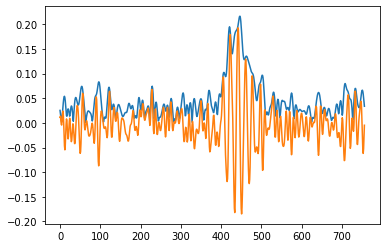

In [138]:
plt.plot(hilbert_transf(p_data[12,:,0]))
plt.plot(p_data[12,:,0])

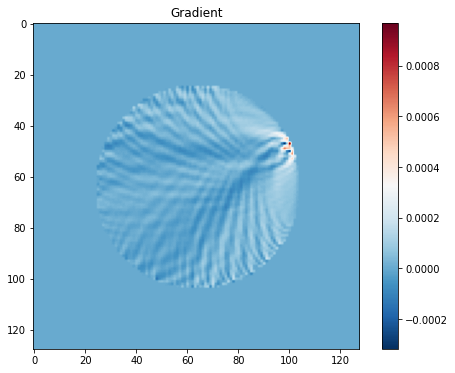

In [139]:
loss, gradient = loss_with_grad(
    params, 
    source_num=10, 
    trace_start_time = time_axis.t_end*(1 - 1/1.5)
)

# Viualize
plt.figure(figsize=(8,6))
plt.imshow(gradient.on_grid, cmap="RdBu_r")
plt.title("Gradient")
plt.colorbar()
plt.show()

### Minimize the objective function

Equipped with a function that calculates the correct gradients, we can finally run the FWI algorithm by randomly looping trough the sources and update the speed of sound estimate.

Following the spirit of `JAX`, all that is needed to do is to write an `update` function that calculates the gradients and applies a step of the optimization algorithm (but we could have used full batch methods, such as BFGS). In this function, we'll also smooth the gradients: this is not necessarily a smart thing to do, but we use it here to highlight how the user can customize any step of the algorithms developed using `jwave`.

In [140]:
losshistory = []
reconstructions = []
num_steps = 200

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(.1, 0.9, 0.9)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    start_time = 0.#time_axis.t_end*(1 - k/num_steps)
    lossval, gradient = loss_with_grad(v, src_num, start_time)
    
    return lossval, update_fun(k, gradient, opt_state)

# Main loop
pbar = tqdm(range(num_steps))
_, key = random.split(random_seed)
for k in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, k)
    
    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_density(new_params).on_grid)
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))

Loss: 0.02182646282017231: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.93it/s]


Finally, let's look at the reconstructed image and its evolution during the optimization

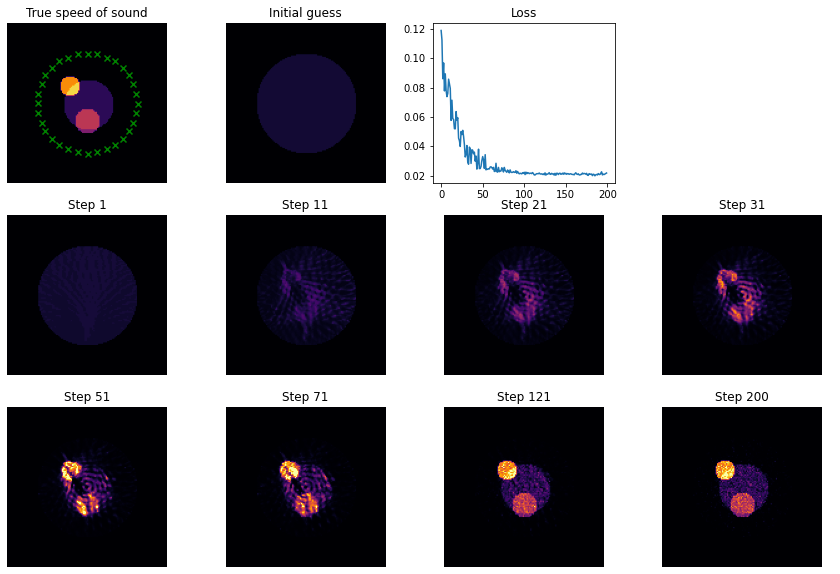

In [141]:
sos_original = get_sound_speed(params).on_grid
true_sos = sound_speed.on_grid

fig, axes = plt.subplots(3,4, figsize=(15,10))

k = 0
recs = [0, 10, 20, 30, 50, 70, 120, 199]
for row in range(3):
    for col in range(4):
        if k ==0:
            axes[row,col].imshow(true_sos, cmap="inferno", vmax=1.2)
            axes[row,col].scatter(sensors_positions[1],sensors_positions[0], c='g', marker='x', label="sensors")
            axes[row,col].set_title("True speed of sound")
            axes[row,col].set_axis_off()
        elif k ==1:
            axes[row,col].imshow(sos_original, cmap="inferno", vmax=1.2)
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Initial guess")
        elif k ==2:
            axes[row,col].plot(losshistory)
            axes[row,col].set_title("Loss")
        elif k == 3:
            axes[row,col].set_axis_off()
        else:
            axes[row,col].imshow(reconstructions[recs[k-4]], cmap="inferno", vmax=1.2)
            axes[row,col].set_axis_off()
            axes[row,col].set_title("Step {}".format(recs[k-4]+1))
        k += 1
        
#plt.savefig('fwi.png')